In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.sparse import csc_matrix
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from scipy import sparse as sp

In [3]:
import claude as cl
from claude import observables as obs
from claude import constraints as const

In [4]:
from importlib import reload
reload(obs)
reload(cl)
reload(const)

<module 'claude.constraints' from '/Users/reema/Postdoc/Progetti/MAXENT/claude/claude/constraints.py'>

In [5]:

N = 1000
ba = nx.erdos_renyi_graph(N,0.1)
gn = nx.scale_free_graph(1000)
bp = nx.bipartite.random_graph(1000,400,0.1)
ba_adj = np.asarray(nx.adj_matrix(ba).todense())
gn_adj = np.sign(np.asarray(nx.adj_matrix(gn).todense()))
bp_adj = np.asarray(nx.adj_matrix(bp).todense())[:1000,1000:]
d = np.array(ba_adj.sum(axis=0)).flatten()
dinv = 1/d

din = np.array(gn_adj.sum(axis=0)).flatten()
dout = np.array(gn_adj.sum(axis=1)).flatten()

bp_din = np.array(bp_adj.sum(axis=0)).flatten()
bp_dout = np.array(bp_adj.sum(axis=1)).flatten()

In [6]:
def plot_adj(adj, vmax=1):
    plt.imshow(adj,cmap=matplotlib.cm.get_cmap('gray_r'),vmin=0,vmax=vmax)
    plt.colorbar()

# Test

In [7]:
m1 = cl.GraphEnsemble(1000)
m2 = cl.BipartiteGraphEnsemble(1000,400)
ges = cl.GraphEnsembleSet([m1,m2],[['proteins','proteins'],['proteins','mirna']])
#m.fit([const.DegreeSequence(d)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})
#m.fit([const.BipartiteOutDegreeSequence(bp_dout),const.BipartiteInDegreeSequence(bp_din)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

In [8]:
ges.fit([[const.DegreeSequence(d)],[const.BipartiteOutDegreeSequence(bp_dout),const.BipartiteInDegreeSequence(bp_din)]], opt_kwargs=[{'nit':32,'fatol':1e-2,'disp':True},{'nit':100,'fatol':1e-2,'disp':True}])


0:  |F(x)| = 23.9007; step 1
1:  |F(x)| = 11.7973; step 1
2:  |F(x)| = 3.50258; step 1
3:  |F(x)| = 1.09361; step 1
4:  |F(x)| = 0.218471; step 1
5:  |F(x)| = 0.273144; step 1
6:  |F(x)| = 0.0874826; step 1
7:  |F(x)| = 0.01761; step 1
8:  |F(x)| = 0.00401002; step 1
9:  |F(x)| = 0.00247286; step 1
10:  |F(x)| = 0.000592961; step 1
11:  |F(x)| = 6.57082e-05; step 1
12:  |F(x)| = 3.40112e-05; step 1
13:  |F(x)| = 1.76952e-05; step 1
14:  |F(x)| = 3.81353e-06; step 1
15:  |F(x)| = 9.21373e-07; step 1
16:  |F(x)| = 3.05788e-07; step 1
17:  |F(x)| = 1.14055e-07; step 1
18:  |F(x)| = 2.00595e-08; step 1
19:  |F(x)| = 5.34422e-09; step 1
20:  |F(x)| = 2.09315e-09; step 1
21:  |F(x)| = 7.00041e-10; step 1
22:  |F(x)| = 2.11358e-10; step 1
23:  |F(x)| = 1.09154e-10; step 1
24:  |F(x)| = 4.29452e-11; step 1
25:  |F(x)| = 1.73088e-11; step 1
26:  |F(x)| = 4.34852e-12; step 1
27:  |F(x)| = 2.41585e-12; step 1
28:  |F(x)| = 7.95808e-13; step 1
29:  |F(x)| = 2.55795e-13; step 1
30:  |F(x)| = 9.9476

# One step

In [25]:
def propagate_nstep(adj,x,n):
    spadj = sp.csr_matrix(adj)**n
    return spadj.T.dot(x)
x = np.zeros(1000)
y = np.zeros(1000)
x[:20] = 1.
y[100:110]=1.

In [26]:
length = 1
vals = np.zeros([1000,1000])
for i in trange(vals.shape[0]):
    radj = m1.sample()
    vals[i,:] = propagate_nstep(radj,x,length)

KeyboardInterrupt: 

In [27]:
length = 1
vals = np.zeros(1000)
for i in trange(vals.shape[0]):
    radj = m1.sample()
    vals[i] = (y*propagate_nstep(radj,x,length)).sum()

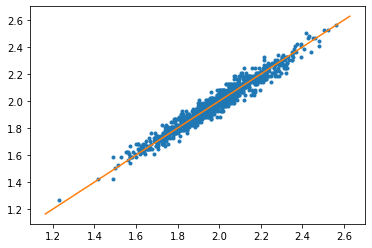

In [20]:
plt.plot(vals.mean(axis=0),m1.predict_mean(obs.SumOfPaths(x)),'.')
plt.plot(plt.xlim(),plt.xlim())

In [28]:
vals.mean(axis=0),m1.predict_mean(obs.SumOfPaths(x,y))

(19.396, 19.451577634030848)

In [30]:
vals.std(axis=0),m1.predict_std(obs.SumOfPaths(x,y))

(4.297346157804838, 4.187520495644869)

In [34]:
np.sqrt(((x[:,None]*y[None,:]*m1.sigma)**2).sum())

4.187520495644869

In [35]:
m1.predict_std(obs.Connectivity(np.where(x)[0],np.where(y)[0]))

4.187520495644869

# Compound propagation

In [36]:
def propagate_compound(adj_list,x):
    spadjs = [sp.csr_matrix(adj) for adj in adj_list]
    outvec = x
    for i in range(len(adj_list)):
        outvec = adj_list[i].T.dot(outvec)
    return outvec
x = np.zeros(1000)
y = np.zeros(400)
x[:200] = 1.
y[200:300]=1.

In [37]:
length = 1
vals = np.zeros(1000)
for i in trange(vals.shape[0]):
    radj1 = m1.sample()
    radj2 = m2.sample()
    vals[i] = (y*propagate_compound([radj1,radj2],x)).sum()

In [38]:
vals.mean()

196494.895

In [39]:
o = obs.CompoundObservable([obs.SumOfPaths(x), obs.SumOfPaths(None,y)],[['proteins','proteins'],['proteins','mirna']])

In [40]:
ges.predict_mean(o)

196518.14004170787

In [41]:
ges.predict_std(o)

2302.8148918591346

In [42]:
vals.std()

2406.497303130631

# Compound propagation more matrices

In [7]:
g1 = nx.barabasi_albert_graph(1000,20)
g2 = nx.bipartite.random_graph(1000,400,0.1)
g3 = nx.bipartite.random_graph(400,700,0.1)
g4 = nx.erdos_renyi_graph(700,0.1)
graphs = [g1,g2,g3,g4]
adjs = [np.asarray(nx.adj_matrix(g).todense()) for g in graphs]
adjs[1] = adjs[1][:1000,1000:]
adjs[2] = adjs[2][:400,400:]
d1 = np.array(adjs[0].sum(axis=0)).flatten()
din2 = np.array(adjs[1].sum(axis=0)).flatten()
dout2 = np.array(adjs[1].sum(axis=1)).flatten()
din3 = np.array(adjs[2].sum(axis=0)).flatten()
dout3 = np.array(adjs[2].sum(axis=1)).flatten()
d4 = np.array(adjs[3].sum(axis=0)).flatten()


In [8]:
m1 = cl.GraphEnsemble(1000)
m2 = cl.BipartiteGraphEnsemble(1000,400)
m3 = cl.BipartiteGraphEnsemble(400,700)
m4 = cl.GraphEnsemble(700)


In [9]:
ges.check_consistency(ges.ge_list,[['n1','n2'],['n2','n3'],['n4','n5'],['n3','n4']] )

NameError: name 'ges' is not defined

In [10]:
ges = cl.GraphEnsembleSet([m1,m2,m3,m4],[['n1','n2'],['n2','n3'],['n3','n4'],['n4','n5']])
ges.fit([[const.DegreeSequence(d1)],
         [const.BipartiteOutDegreeSequence(dout2),const.BipartiteInDegreeSequence(din2)],
         [const.BipartiteOutDegreeSequence(dout3),const.BipartiteInDegreeSequence(din3)],
        [const.DegreeSequence(d4)]], opt_kwargs=[{'nit':30,'fatol':1e-2,'disp':True}]*4)


0:  |F(x)| = 89.4545; step 1
1:  |F(x)| = 45.8853; step 1
2:  |F(x)| = 87.1376; step 1
3:  |F(x)| = 202.174; step 1
4:  |F(x)| = 195.121; step 1
5:  |F(x)| = 42.1859; step 1
6:  |F(x)| = 31.5585; step 0.420005
7:  |F(x)| = 3.29088; step 1
8:  |F(x)| = 1.74145; step 1
9:  |F(x)| = 1.50674; step 1
10:  |F(x)| = 0.556779; step 1
11:  |F(x)| = 0.428419; step 1
12:  |F(x)| = 0.366823; step 1
13:  |F(x)| = 0.140074; step 1
14:  |F(x)| = 0.105454; step 1
15:  |F(x)| = 0.0766483; step 1
16:  |F(x)| = 0.061031; step 1
17:  |F(x)| = 0.0197647; step 1
18:  |F(x)| = 0.0169875; step 1
19:  |F(x)| = 0.0127876; step 1
20:  |F(x)| = 0.0054248; step 1
21:  |F(x)| = 0.00322374; step 1
22:  |F(x)| = 0.00277818; step 1
23:  |F(x)| = 0.00171633; step 1
24:  |F(x)| = 0.00127048; step 1
25:  |F(x)| = 0.00080865; step 1
26:  |F(x)| = 0.000729436; step 1
27:  |F(x)| = 0.000557828; step 1
28:  |F(x)| = 0.000383001; step 1
29:  |F(x)| = 0.000291375; step 1
0:  |F(x)| = 30.5888; step 0.103264
1:  |F(x)| = 32.1508

In [11]:
def propagate_compound(adj_list,x):
    spadjs = [sp.csr_matrix(adj) for adj in adj_list]
    outvec = x
    for i in range(len(adj_list)):
        outvec = adj_list[i].T.dot(outvec)
    return outvec
x = np.zeros(1000)
y = np.zeros(700)
x[:200] = 1.
x = x/x.sum()
y[200:300]=1.

In [12]:
def get_stochastic(m):
    d = np.array(m.sum(axis=1)).flatten()
    return np.asarray(m / d[:, None])

In [13]:
length = 1
vals = np.zeros([100,700])
for i in trange(vals.shape[0]):
    radj1 = get_stochastic(m1.sample())
    radj2 = get_stochastic(m2.sample())
    radj3 = get_stochastic(m3.sample())
    radj4 = get_stochastic(m4.sample())
    vals[i,:] = propagate_compound([radj1,radj2,radj3,radj4],x)

In [46]:
x.shape

(1000,)

In [47]:
length = 1
vals = np.zeros([100,1000])
for i in trange(vals.shape[0]):
    radj1 = get_stochastic(m1.sample())
    radj2 = get_stochastic(m2.sample())
    radj3 = get_stochastic(m3.sample())
    radj4 = get_stochastic(m4.sample())
    vals[i,:] = propagate_compound([radj1],x)

In [23]:
vals.mean(),ges.predict_mean(o)

(461128980.758, 461034942.66803855)

In [14]:
mean_theo = np.zeros(700)
std_theo = np.zeros(700)
for i in trange(700):
    y = np.zeros(700)
    y[i] = 1.
    o = obs.CompoundObservable([obs.Propagation(x, normalized=True), obs.Propagation(normalized=True),obs.Propagation(normalized=True),obs.Propagation(None,y,normalized=True)],[['n1','n2'],['n2','n3'],['n3','n4'],['n4','n5']])
    mean_theo[i] = ges.predict_mean(o)
    std_theo[i] = ges.predict_std(o)

In [53]:
std_theo = np.zeros(1000)
mean_theo = np.zeros(1000)
for i in trange(1000):
    y = np.zeros(1000)
    y[i] = 1.
    o = obs.CompoundObservable([obs.Propagation(x, y, normalized=True)],[['n1','n2'],['n2','n3'],['n3','n4'],['n4','n5']])
    mean_theo[i] = ges.predict_mean(o)
    std_theo[i] = ges.predict_std(o)

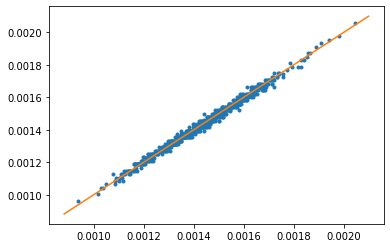

In [15]:
plt.plot(vals.mean(axis=0),mean_theo,'.')
plt.plot(plt.xlim(),plt.xlim())

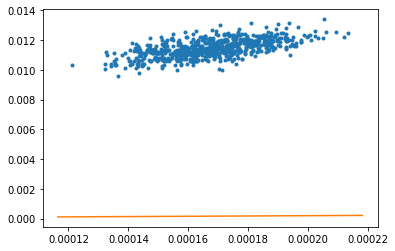

In [16]:
plt.plot(vals.std(axis=0),std_theo,'.')
plt.plot(plt.xlim(),plt.xlim())

In [29]:
vals.std(),ges.predict_std(o)

(7748765.866415226, 7236876.076995304)

# NML

In [ ]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/observables.py(296)backprop()
    294                                 f_args = list(self[i].f_args)
    295                                 f_args[self[len(self)-i-1].input_variable_index] = obs_value
--> 296                                 obs_value = self[len(self)-i-1].backprop(adj_list[len(self)-i-1], *f_args)
    297                 elif self.reduce_func == 'sum':
    298                         raise NotImplementedError

ipdb> i
0
ipdb> len(self)-i-1
1


In [ ]:
len()

In [14]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/observables.py(296)backprop()
    294                                 f_args = list(self[i].f_args)
    295                                 f_args[self[len(self)-i-1].input_variable_index] = obs_value
--> 296                                 obs_value = self[len(self)-i-1].backprop(adj_list[len(self)-i-1], *f_args)
    297                 elif self.reduce_func == 'sum':
    298                         raise NotImplementedError

ipdb> len(self)-i-1
1
ipdb> adj_list[len(self)-i-1]
*** IndexError: list index out of range
ipdb> len(adj_list)
1
ipdb> adj_list
[array([[0.08586498, 0.09210363, 0.09567488, ..., 0.08675535, 0.08408508,
        0.09567488],
       [0.10801711, 0.11566162, 0.12002555, ..., 0.10910978, 0.10583119,
        0.12002555],
       [0.09570682, 0.10258031, 0.10651012, ..., 0.09668846, 0.09374383,
        0.10651012],
       ...,
       [0.0883249 , 0.09472377, 0.0983856 , ..., 0.0892383 , 0.08649884,
        0.0983856 ]

In [23]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/observables.py(244)func()
    242                 o = input_vector
    243                 for i in range(length):
--> 244                         o = o.dot(adj)
    245                 if proj_vector is None:
    246                         return o

ipdb> o
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 

ipdb> self[i].f_args
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [ ]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/base.py(261)<listcomp>()
    259 
    260         def predict_mean(self, obs):
--> 261                 adj_list = [self.ge_list.adj_matrix[i] for i in range(len(self.ge_list))]
    262                 return obs.func(adj_list)
    263 

ipdb> self.ge_list
[<claude.base.GraphEnsemble object at 0x7fe777f6aba8>, <claude.base.BipartiteGraphEnsemble object at 0x7fe777f6a2e8>]


In [22]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/observables.py(255)grad()
    253                 term = 0
    254                 for l in range(length):
--> 255                         term = term + input_vector.dot(powers[l])[:,None] * powers[length - 1 - l].dot(proj_vector)[None, :]
    256                 return term
    257 

ipdb> len(powers)
2
ipdb> input_vector.dot(powers[l])
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [9]:
def propagate_nstep(adj,x,n):
    spadj = sp.csr_matrix(adj)**n
    return spadj.T.dot(x)

In [144]:
def propagate_nstep_corr(adj,x,n):
    spadj = sp.csr_matrix(adj)**n
    spadj = np.asarray(spadj.todense())
    np.fill_diagonal(spadj,adj.sum(axis=0))
    return x.dot(spadj).flatten()

In [145]:
def propagate_nstep_corr2(adj,x,n):
    spadj = sp.csr_matrix(adj)**n
    spadj = np.asarray(spadj.todense())
    np.fill_diagonal(spadj,adj.sum(axis=0))
    return x.dot(spadj).flatten().sum()

In [149]:
x.dot(np.linalg.matrix_power(m1.adj_matrix,2)) + 2 * x.dot(m1.sigma**2)

array([10.09827121,  9.04540432,  9.55528611, 11.38794329,  9.6572197 ,
        9.45333829, 10.57398666,  9.86104432, 10.06481239, 11.08281285,
       10.67577961, 10.98107526,  8.7393033 ,  9.96293541, 10.37035895,
        9.35137623,  8.84135136,  9.6572197 ,  9.86104432, 11.08281285,
       10.06481239,  9.35137623,  9.86104432,  9.45333829,  9.96293541,
       10.67577961, 10.77755867, 13.11473001,  9.86104432, 10.47217978,
       11.08281285,  8.7393033 ,  9.96293541, 10.47217978, 12.09943887,
       10.57398666, 10.16667528,  9.96293541, 10.77755867, 10.57398666,
        9.75913909, 12.30260252, 11.59129533,  9.75913909,  9.86104432,
       10.47217978,  8.84135136,  9.86104432, 11.38794329,  9.75913909,
       10.06481239, 10.16667528,  9.35137623, 10.77755867, 10.47217978,
       10.47217978, 11.08281285, 10.87932388,  9.75913909,  9.75913909,
       11.99783703, 11.99783703, 11.28624683,  9.45333829,  9.14740927,
       11.28624683, 11.99783703, 10.87932388, 10.87932388,  9.65

In [12]:
length = 1
vals = np.zeros([300,1000])
for i in trange(vals.shape[0]):
    radj = m1.sample()
    vals[i,:] = propagate_nstep(radj,x,length)

AttributeError: module 'jax.scipy.sparse' has no attribute 'csr_matrix'

In [146]:
propagate_nstep_corr2(m1.adj_matrix,x,length)

10079.792185331708

In [147]:
vals.sum(axis=1).mean()

10113.623333333333

In [143]:
propagate_nstep_corr(m1.adj_matrix,x,length)

10079.792185331708

In [ ]:
plt.plot(vals.mean(axis=0),x.dot(np.linalg.matrix_power(m1.adj_matrix,2)) + x * (m1.sigma**2).sum(axis=0),'.')
plt.plot(plt.xlim(),plt.xlim())

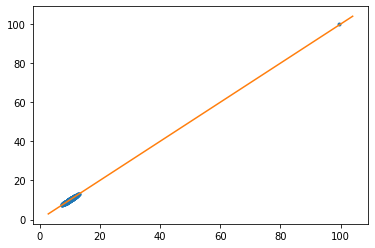

In [148]:
plt.plot(vals.mean(axis=0),propagate_nstep_corr(m1.adj_matrix,x,length),'.')
plt.plot(plt.xlim(),plt.xlim())

In [126]:
(m1.adj_matrix[i,:]**2).sum()

9.898395532469255

In [11]:
x = np.zeros(1000)
y = np.zeros(1000)
x[:20] = 1.
y[100:110]=1.

In [27]:
ges['proteins','proteins'].predict_mean(obs.SumOfPaths(x,y,3))

12623701.802730799

In [50]:
(sp.csr_matrix(adj)**1).todense()

NameError: name 'adj' is not defined

In [60]:
def sumofpaths(adj,l):
    padj = sp.csr_matrix(adj)
    xpow = x
    for i in range(l):
        xpow = padj.dot(xpow)
    return (xpow*y).sum()

In [89]:
def sumofpaths2(adj,l):
    padj = sp.csr_matrix(adj)
    xpow = x
    for i in range(l):
        xpow = padj.dot(xpow)
    return xpow

In [99]:
def sumofpaths3(adj,l):
    padj = np.linalg.matrix_power(adj,l)
    #np.fill_diagonal(padj,np.diag(adj))
    return x.dot(padj)

In [108]:
def propagate_nstep(adj,n):
    p = sp.csr_matrix(adj)#utils.normalize_rows(adj.tocsr())
    y = x.copy()
    x0 = x.dot(np.eye(N))
    for t in range(n):
        y = p.T.dot(y)
    return y

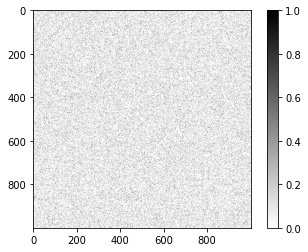

In [81]:
plot_adj(m1.sample())

In [87]:
m1.sigma

array([[0.        , 0.32321591, 0.3143452 , ..., 0.31820426, 0.31820426,
        0.31303901],
       [0.32321591, 0.        , 0.30419627, ..., 0.30816285, 0.30816285,
        0.3028547 ],
       [0.3143452 , 0.30419627, 0.        , ..., 0.29891644, 0.29891644,
        0.29349022],
       ...,
       [0.31820426, 0.30816285, 0.29891644, ..., 0.        , 0.30293449,
        0.29755798],
       [0.31820426, 0.30816285, 0.29891644, ..., 0.30293449, 0.        ,
        0.29755798],
       [0.31303901, 0.3028547 , 0.29349022, ..., 0.29755798, 0.29755798,
        0.        ]])

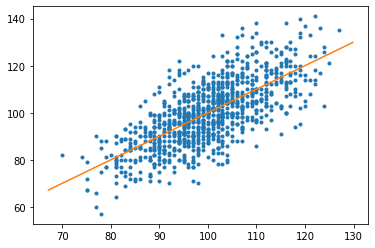

In [85]:
plt.plot(m1.adj_matrix.sum(axis=0), m1.sample().sum(axis=0),'.')
plt.plot(plt.xlim(),plt.xlim())

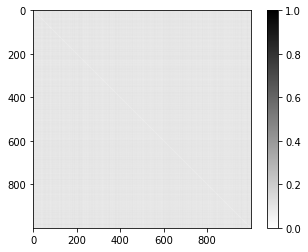

In [82]:
plot_adj(m1.adj_matrix)

In [71]:
plt.plot(sumofpaths2(m1.adj_matrix,2),

array([116.00120765, 107.84010291, 100.69434009,  96.60898673,
       103.75736677,  96.60898673, 109.88092062, 101.71544252,
       109.88092062, 102.73645129, 100.68508627, 104.76732334,
       101.7058001 , 100.68508627, 111.90731734, 118.02342565,
        97.62232178,  86.38407106,  87.40626339, 117.00431931,
       105.78762617, 102.72641066,  93.5371702 ,  97.62232178,
       100.68508627, 103.74691829, 101.7058001 , 105.78762617,
        97.62232178, 105.78762617,  97.62232178,  97.62232178,
       109.86782266,  91.49396081, 130.24526427,  90.4721967 ,
       108.84792501,  86.38407106,  92.51561855,  98.64334744,
        95.5799564 ,  99.66426882,  89.45032594,  83.31684677,
       112.92691517, 102.72641066, 119.04243499,  91.49396081,
       103.74691829, 111.90731734, 106.80782715, 105.78762617,
       112.92691517, 106.80782715, 102.72641066, 109.86782266,
       106.80782715, 112.92691517, 104.76732334, 104.76732334,
       100.68508627,  98.64334744, 103.74691829,  94.55

In [10]:
from scipy import sparse as sp

In [51]:
((sp.csr_matrix(radj)**1).dot(x)*y).sum()

1999.0

In [45]:
vals1 = np.zeros(300)
for i in trange(len(vals)):
    radj = ges['proteins','proteins'].sample()
    vals1[i] = sumofpaths(radj,1)
    

In [48]:
ges['proteins','proteins'].predict_mean(obs.SumOfPaths(x,y,1))

2015.6942623850564

In [57]:
x.dot(np.linalg.matrix_power(ges['proteins','proteins'].adj_matrix,3)).dot(y)

12623701.802730799

In [54]:
length = 1
vals = np.zeros(300)
for i in trange(len(vals)):
    radj = ges['proteins','proteins'].sample()
    vals[i] = sumofpaths(radj,length)
    
plt.hist(vals)
plt.axvline(m1.predict_mean(obs.SumOfPaths(x,y,length)),color='red')
print(m1.predict_std(obs.SumOfPaths(x,y,length)),vals.std())

NameError: name 'sumofpaths' is not defined

TypeError: func() missing 2 required positional arguments: 'adj' and 'input_vector'

In [53]:
obs.SumOfPaths(x,length=length).func(radj,x)

array([0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 3., 3., 3., 4.,
       1., 1., 2., 3., 1., 1., 1., 1., 3., 0., 0., 0., 1., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 2., 3., 0., 0., 0., 3., 1., 0., 2., 0., 2., 1.,
       2., 0., 2., 1., 2., 0., 0., 0., 0., 0., 1., 3., 1., 1., 0., 1., 2.,
       1., 2., 0., 0., 2., 0., 0., 1., 3., 3., 1., 0., 1., 2., 2., 1., 2.,
       2., 0., 1., 0., 0., 1., 0., 0., 0., 2., 2., 2., 2., 0., 1., 0., 0.,
       4., 3., 0., 1., 0., 0., 2., 1., 1., 1., 0., 3., 3., 2., 1., 1., 1.,
       2., 2., 0., 1., 1., 0., 1., 1., 1., 1., 2., 1., 1., 2., 0., 1., 2.,
       1., 0., 3., 1., 2., 1., 1., 0., 1., 1., 1., 1., 1., 1., 2., 1., 3.,
       0., 2., 0., 3., 1., 0., 3., 2., 1., 0., 4., 0., 0., 1., 0., 3., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 1., 2., 1., 2., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 2., 1., 1., 0., 1., 1., 0., 0., 0.,
       2., 1., 0., 2., 1., 0., 1., 0., 0., 4., 2., 2., 0., 0., 0., 0., 3.,
       1., 1., 0., 1., 1.

In [109]:
length = 2
vals = np.zeros([300,1000])
for i in trange(vals.shape[0]):
    radj = ges['proteins','proteins'].sample()
    vals[i,:] = propagate_nstep(radj,length)
    

[1000]

In [21]:
ccs = np.zeros(300)
for i in trange(300):
    ccs[i] = max([len(cc) for cc in nx.connected_components(nx.from_numpy_matrix(ges['proteins','proteins'].sample()))])

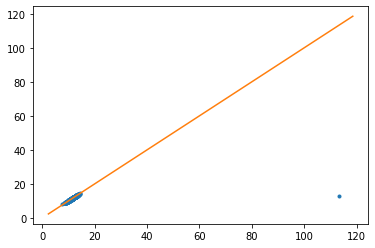

In [110]:
plt.plot(vals.mean(axis=0),sumofpaths3(ges['proteins','proteins'].adj_matrix,2),'.')
plt.plot(plt.xlim(),plt.xlim())

In [92]:
ges['proteins','proteins'].adj_matrix

array([[0.        , 0.11851412, 0.11117215, ..., 0.1143239 , 0.1143239 ,
        0.11011979],
       [0.11851412, 0.        , 0.10318187, ..., 0.10625433, 0.10625433,
        0.10215702],
       [0.11117215, 0.10318187, 0.        , ..., 0.09918962, 0.09918962,
        0.09519945],
       ...,
       [0.1143239 , 0.10625433, 0.09918962, ..., 0.        , 0.10221778,
        0.09818008],
       [0.1143239 , 0.10625433, 0.09918962, ..., 0.10221778, 0.        ,
        0.09818008],
       [0.11011979, 0.10215702, 0.09519945, ..., 0.09818008, 0.09818008,
        0.        ]])

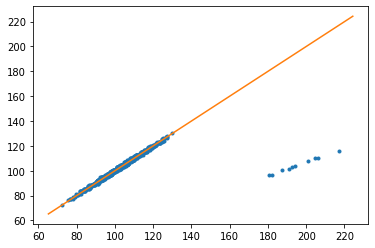

In [68]:
plt.plot(vals.mean(axis=0),ges['proteins','proteins'].predict_mean(obs.SumOfPaths(x,length=length)),'.')
plt.plot(plt.xlim(),plt.xlim())

In [61]:
plt.plot(vals.std(axis=0),ges['proteins','proteins'].predict_std(obs.SumOfPaths(x,length=length)),'.')
plt.plot(plt.xlim(),plt.xlim())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

234574.0327539533 282440.0325471328


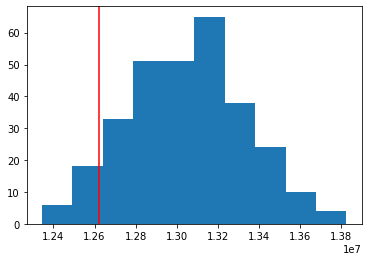

In [44]:
plt.hist(vals)
plt.axvline(ges['proteins','proteins'].predict_mean(obs.SumOfPaths(x,y,3)),color='red')
print(ges['proteins','proteins'].predict_std(obs.SumOfPaths(x,y,3)),vals.std())

In [20]:
%debug

> /Users/reema/Postdoc/Progetti/MAXENT/claude/claude/observables.py(223)grad()
    221                 term = 0
    222                 for l in range(length):
--> 223                         term = term + input_vector.dot(powers[l][:,None]) * powers[length - 1 - l].dot(proj_vector)[None, :]
    224                 return term
    225 

ipdb> input_vector.dot(powers[l][:,None]).shape
*** ValueError: shapes (1000,) and (1000,1,1000) not aligned: 1000 (dim 0) != 1 (dim 1)
ipdb> input_vector.dot(powers[l])[:,None]
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
  

ipdb> input_vector.dot(powers[l][:,None]).shape
*** ValueError: shapes (1000,) and (1000,1,1000) not aligned: 1000 (dim 0) != 1 (dim 1)
ipdb> input_vector.dot(powers[l])[:,None].shape
(1000, 1)
ipdb> exit


In [ ]:
m = cl.BipartiteGraphEnsemble(1000,400)
m.fit([const.BipartiteOutDegreeSequence(bp_dout),const.BipartiteInDegreeSequence(bp_din)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})